# <font size="10">$$\text{Ứng dụng thực tế liên ngành}$$</font>

In [1]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def display_images(images, titles, max_cols=3):
    num_images = len(images)
    num_rows = math.ceil(num_images / max_cols)
    
    plt.figure(figsize=(max_cols * 5, num_rows * 5))
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(num_rows, max_cols, i + 1)
        if len(img.shape) == 3:
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(title, fontsize=12)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show();

## $\text{Trong y tế}$

### $\text{Đếm tế bào máu}$

In [3]:
def count_blood_cells(original_image, it=1, min_area=50):
    image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)

    blurred_image = cv.GaussianBlur(image, (5, 5), 0)

    _, binary_mask = cv.threshold(blurred_image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # Opening: Loại bỏ các chấm trắng nhỏ ở nền
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    dilated = cv.dilate(binary_mask, kernel, iterations=it)

    opening = cv.morphologyEx(dilated, cv.MORPH_OPEN, kernel, iterations=it)
    
    # Closing: Lấp đầy các lỗ đen nhỏ bên trong tế bào
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel, iterations=it)

    # findContours sẽ tìm các đường biên của vật thể trắng trên nền đen.
    contours, _ = cv.findContours(closing, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Lọc các contour quá nhỏ (có thể là nhiễu còn sót lại)
    valid_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_area]
    
    cell_count = len(valid_contours)

    # Vẽ các contour tìm được lên ảnh gốc
    output_image = original_image.copy()
    cv.drawContours(output_image, valid_contours, -1, (0, 0, 255), 2) 
    
    # Hiển thị các bước xử lý để làm báo cáo
    display_images(
        [original_image, image, binary_mask, closing, output_image],
        ["Anh Goc", "Anh Xam", "Nguong Otsu", "Loc Nhieu (Closing)", f"Ket Qua Cuoi Cung: {cell_count} te bao"]
    )


### $\text{Tách khối u trong ảnh MRI}$

In [4]:
def segment_tumor(original_image):
    image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)

    # Áp dụng Gaussian Blur để giảm nhiễu
    image_blur = cv.blur(image, (3, 3), 0)
    
    watershed = segment_by_watershed(image_blur)        
    
    # Vẽ contour màu đỏ quanh khối u
    contours, _ = cv.findContours(watershed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    output_image = original_image.copy()
    cv.drawContours(output_image, contours, -1, (0, 0, 255), 2)    
    
    display_images(
        [original_image, image, image_blur, watershed, output_image],
        ["Anh Goc", "Anh Xam", "Loc Nhieu Gaussian", "Anh Hau Xu Ly", "Ket Qua"]
    )


def segment_by_watershed(image):
    # Threshold để tìm vùng chắc chắn là background
    _, binary_mask = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    # Sure background: dilation của threshold
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    dilated = cv.dilate(binary_mask, kernel, iterations=3)
    
    # Sure foreground: distance transform + threshold
    # Distance transform: tính khoảng cách đến pixel background gần nhất
    dist_transform = cv.distanceTransform(binary_mask, cv.DIST_L2, 5)
    _, sure_fg = cv.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Unknown region: vùng không chắc chắn
    unknown = cv.subtract(dilated, sure_fg)
    
    # Marker labeling: gán nhãn cho các vùng foreground
    _, markers = cv.connectedComponents(sure_fg)
    markers = markers + 1  # Background = 1
    markers[unknown == 255] = 0  # Unknown = 0
    
    # Áp dụng watershed
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    markers = cv.watershed(image_color, markers)
    
    # Tạo mask từ markers (loại bỏ boundary = -1)
    mask = np.zeros_like(image)
    mask[markers > 1] = 255  # Các vùng foreground
    
    return mask

## $\text{Nông nghiệp}$

### $\text{Phát hiện sâu bệnh trên lá}$

In [5]:
def segment_by_excluding_green(original_image):
    hsv_image = cv.cvtColor(original_image, cv.COLOR_BGR2HSV)

    # === Bước 2: Tách lá ra khỏi nền (Background) ===
    # Tạo một dải màu xanh "rộng" để lấy gần như toàn bộ chiếc lá
    leaf_lower_bound = np.array([25, 40, 40])
    leaf_upper_bound = np.array([85, 255, 255])
    leaf_mask = cv.inRange(hsv_image, leaf_lower_bound, leaf_upper_bound)
    
    # Lọc nhiễu cho mask lá
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    leaf_mask = cv.morphologyEx(leaf_mask, cv.MORPH_CLOSE, kernel)
    
    # Chỉ giữ lại phần là chiếc lá, loại bỏ hoàn toàn nền
    leaf_only_image = cv.bitwise_and(original_image, original_image, mask=leaf_mask)

    # Chuyển ảnh chỉ có lá sang HSV
    leaf_only_hsv = cv.cvtColor(leaf_only_image, cv.COLOR_BGR2HSV)
    
    # Tạo một dải màu xanh "hẹp" và "chuẩn" hơn để định nghĩa vùng khỏe mạnh
    healthy_lower_bound = np.array([35, 50, 50])
    healthy_upper_bound = np.array([80, 255, 255])
    
    healthy_mask = cv.inRange(leaf_only_hsv, healthy_lower_bound, healthy_upper_bound)
    
    # Vùng bệnh = (Toàn bộ lá) - (Vùng lá khỏe mạnh)
    disease_mask = cv.subtract(leaf_mask, healthy_mask)
    
    disease_mask = cv.morphologyEx(disease_mask, cv.MORPH_OPEN, kernel, iterations=1)
    
    contours, _ = cv.findContours(disease_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    output_image = original_image.copy()
    for cnt in contours:
        if cv.contourArea(cnt) > 50:
            cv.drawContours(output_image, [cnt], -1, (0, 0, 255), 2)

    display_images(
        [original_image, leaf_mask, healthy_mask, disease_mask, output_image],
        ["Ảnh Gốc", "Mask Toàn Bộ Lá", "Mask Lá Khỏe Mạnh", "Mask Bệnh (Lá - Khỏe)", "Kết Quả Cuối Cùng"]
    )

### $\text{Đếm số lượng quả}$

In [6]:
# Định nghĩa khoảng màu HSV cho các loại quả
FRUIT_COLORS = {
    'yellow': {  # Chanh, cam vàng, bưởi
        'lower': np.array([15, 80, 80]),
        'upper': np.array([35, 255, 255]),
        'color': (0, 255, 255)
    },
    'orange': {  # Cam, quýt
        'lower': np.array([5, 100, 100]),
        'upper': np.array([15, 255, 255]),
        'color': (0, 165, 255)
    },
    'green': {  # Xoài xanh, ổi xanh, táo xanh
        'lower': np.array([35, 40, 40]),
        'upper': np.array([85, 255, 255]),
        'color': (0, 255, 0)
    },
    'red': {  # Táo đỏ, dâu tây, cherry
        'lower1': np.array([0, 100, 100]),
        'upper1': np.array([10, 255, 255]),
        'lower2': np.array([160, 100, 100]),
        'upper2': np.array([180, 255, 255]),
        'color': (0, 0, 255)
    },
    'purple': {  # Nho, mận
        'lower': np.array([125, 50, 50]),
        'upper': np.array([155, 255, 255]),
        'color': (255, 0, 255)
    },
    'brown': {  # Kiwi, chà là
        'lower': np.array([10, 50, 20]),
        'upper': np.array([20, 200, 200]),
        'color': (19, 69, 139)
    }
}


def count_fruits(original_image, color):
    hsv_image = cv.cvtColor(original_image, cv.COLOR_BGR2HSV)

    # Tinh chỉnh dải màu này cho phù hợp
    lower = FRUIT_COLORS[color]['lower']
    upper = FRUIT_COLORS[color]['upper']
    fruit_mask = cv.inRange(hsv_image, lower, upper)

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    cleaned_mask = cv.morphologyEx(fruit_mask, cv.MORPH_CLOSE, kernel, iterations=1)
    cleaned_mask = cv.morphologyEx(cleaned_mask, cv.MORPH_OPEN, kernel, iterations=1)
    
    contours, _ = cv.findContours(cleaned_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    output_image = original_image.copy()
    
    for cnt in contours:
        # Lọc theo diện tích tối thiểu để loại bỏ nhiễu
        area = cv.contourArea(cnt)
        if area > 500:
            cv.drawContours(output_image, [cnt], -1, FRUIT_COLORS[color]['color'], 3)

    display_images(
        [original_image, fruit_mask, cleaned_mask, output_image],
        ["Anh Goc", "Mask Mau Qua", "Mask Da Lam Sach", f"Ket Qua Cuoi Cung"]
    )

## $\text{Giao thông}$

### $\text{Nhận diện biển số xe}$

In [40]:
def detect_license_plate(original_image):
    gray_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
    blurred_image = cv.bilateralFilter(gray_image, 11, 17, 17)

    edged_image = cv.Canny(blurred_image, 30, 200)

    # Tạo một kernel hình chữ nhật
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    # Áp dụng phép closing
    closed_image = cv.morphologyEx(edged_image, cv.MORPH_CLOSE, kernel)

    contours, _ = cv.findContours(closed_image.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    plate_contour = None
    
    for cnt in contours:
        # Lấy bounding box để xác định vị trí
        x, y, w, h = cv.boundingRect(cnt)
        
        # Chỉ xét các contour có tâm nằm ở nửa dưới của ảnh
        if (y + h / 2) < (original_image.shape[1] * 0.5):
            continue # Bỏ qua contour này và đi đến contour tiếp theo
        # Lấy hình chữ nhật bao quanh contour (có thể xoay)
        rect = cv.minAreaRect(cnt)
        (x, y), (width, height), angle = rect

        # Đảm bảo width luôn lớn hơn height
        if width < height:
            width, height = height, width
            
        # Lọc theo diện tích
        area = width * height
        if area < 1000 or area > 15000:
            continue
            
        # Lọc theo tỷ lệ khung hình (Aspect Ratio)
        if height == 0: continue
        aspect_ratio = float(width) / height
        
        # Biển số xe thường có aspect ratio từ 2.5 đến 5.5
        if aspect_ratio > 2.5 and aspect_ratio < 5.5:
            # Lấy 4 góc của hình chữ nhật
            box = cv.boxPoints(rect)
            plate_contour = np.int_(box)
            break # Tìm thấy thì dừng lại
            
    output_image = original_image.copy()
    if plate_contour is not None:
        cv.drawContours(output_image, [plate_contour], -1, (0, 255, 0), 3)
        
        mask = np.zeros(gray_image.shape, np.uint8)
        cv.drawContours(mask, [plate_contour], -1, 255, -1)
        plate_image = cv.bitwise_and(original_image, original_image, mask=mask)
        
        display_images(
            [original_image, edged_image, closed_image, output_image, plate_image],
            ["Ảnh Gốc", "Ảnh Cạnh (Canny)", "Ảnh Cạnh Sau Khi 'Close'", "Biển Số Được Phát Hiện", "Vùng Biển Số Đã Tách"]
        )
    else:
        print("Không tìm thấy biển số phù hợp.")
        display_images(
            [original_image, edged_image, closed_image],
            ["Ảnh Gốc", "Ảnh Cạnh (Canny)", "Ảnh Cạnh Sau Khi 'Close' (Không tìm thấy)"]
        )

## $\text{An ninh}$

### $\text{Tách người ra khỏi nền}$

In [51]:
def segment_person(original_image, seed_point, tolerance):
    image_to_fill = original_image.copy()
    
    h, w = image_to_fill.shape[:2]
    
    # Tạo mask cho floodFill
    mask = np.zeros((h + 2, w + 2), np.uint8)

    # Chuyển tolerance thành tuple cho 3 kênh màu B, G, R
    loDiff = (tolerance, tolerance, tolerance)
    upDiff = (tolerance, tolerance, tolerance)
    
    # Flags: 4-connectivity, và tô giá trị 255 vào mask
    flags = 4 | (255 << 8) | cv.FLOODFILL_FIXED_RANGE
    
    cv.floodFill(image_to_fill, mask, seed_point, (255, 0, 0), loDiff, upDiff, flags)
    
    # Lấy phần mask tương ứng với kích thước ảnh gốc (bỏ đi đường viền 1 pixel)
    final_mask = mask[1:-1, 1:-1]
    
    # Áp dụng mask lên ảnh gốc
    foreground_only = cv.bitwise_and(original_image, original_image, mask=final_mask)

    image_with_seed = original_image.copy()
    cv.circle(image_with_seed, seed_point, 5, (0, 0, 255), -1) # Vẽ điểm mầm
    
    display_images(
        [image_with_seed, image_to_fill, cv.cvtColor(final_mask, cv.COLOR_GRAY2BGR), foreground_only],
        ["Ảnh Gốc với Điểm Mầm", "Kết quả tô màu của FloodFill", "Mask Kết Quả", "Người Đã Được Tách"]
    )

________________________________________________________________________________________________________________________________________________

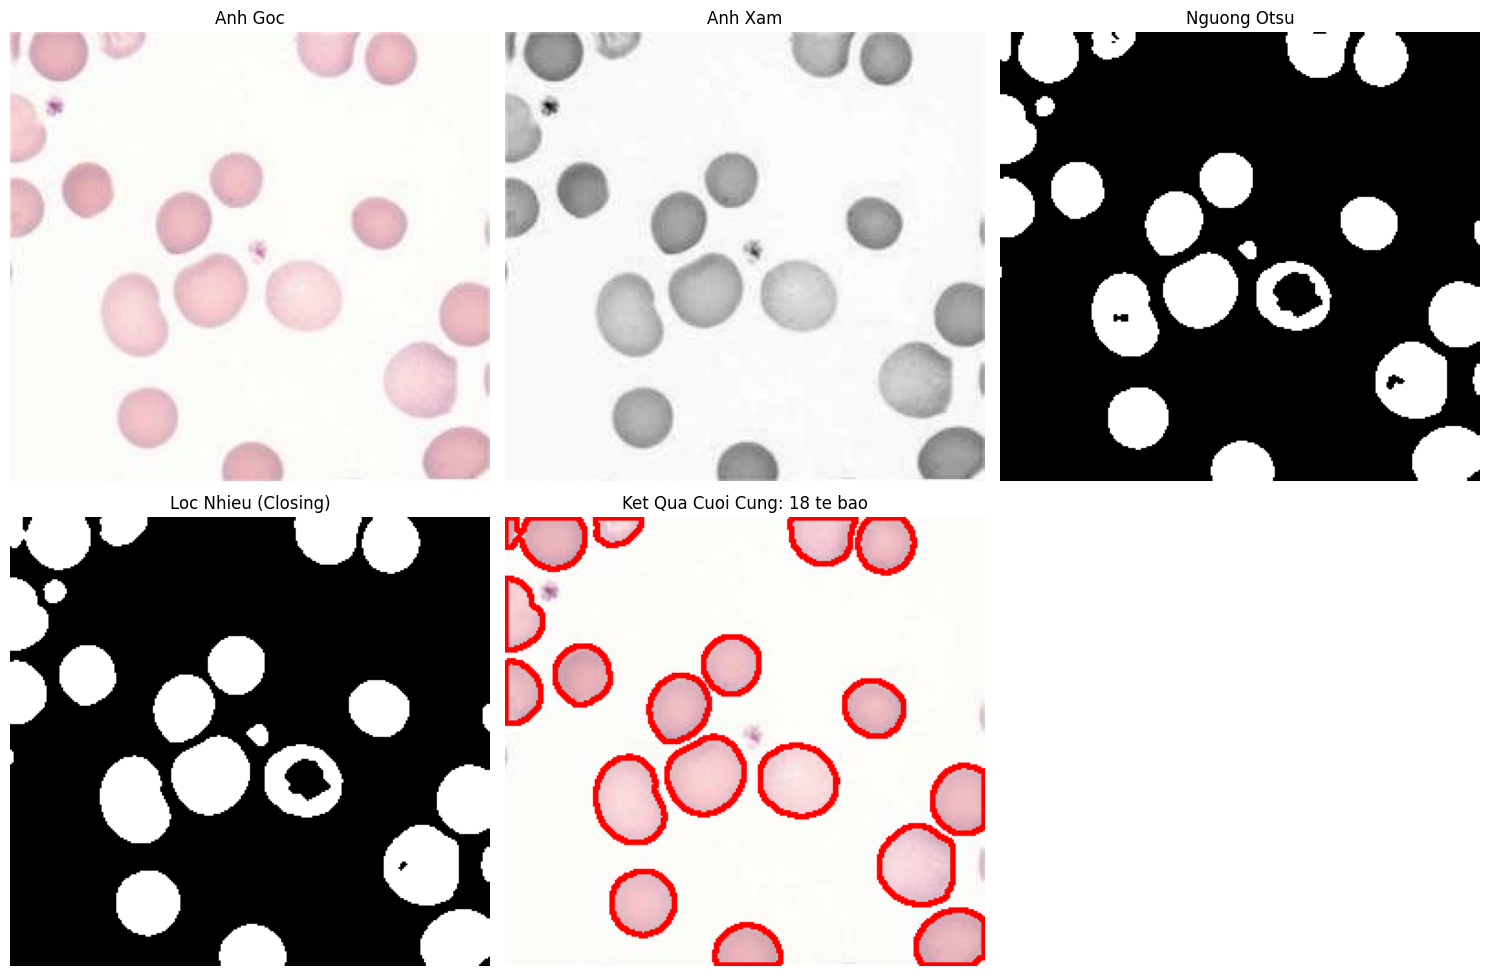

In [87]:
hong_cau = cv.imread('img/hong_cau2.jpg')
count_blood_cells(hong_cau, 1, 110)

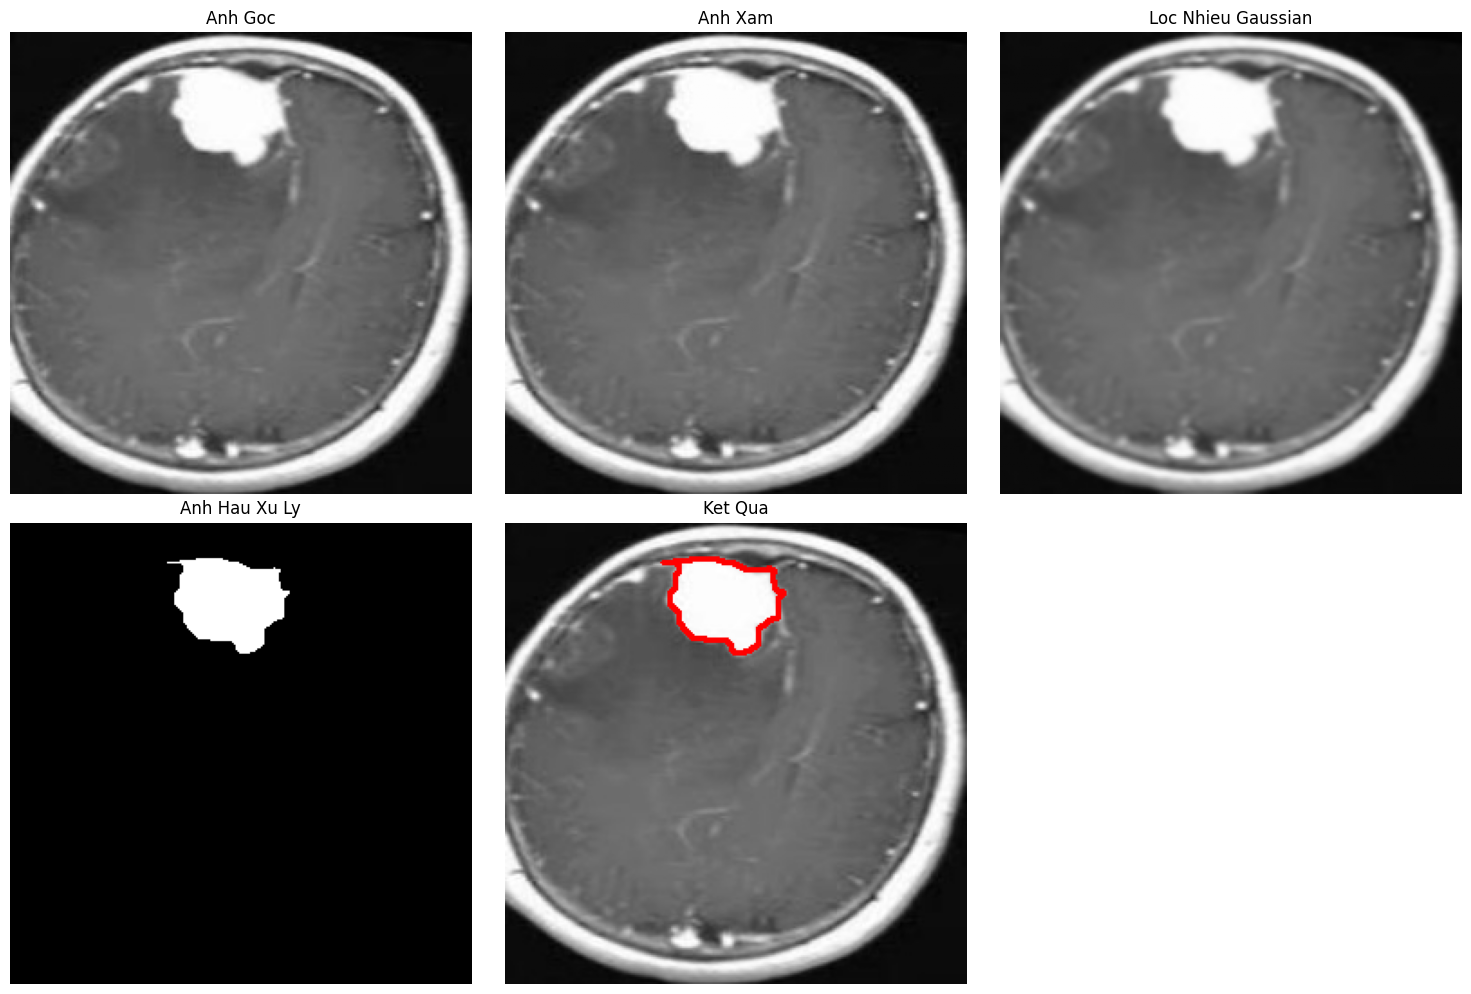

In [88]:
khoi_u = cv.imread('img/khoi_u2.jpg')
segment_tumor(khoi_u)

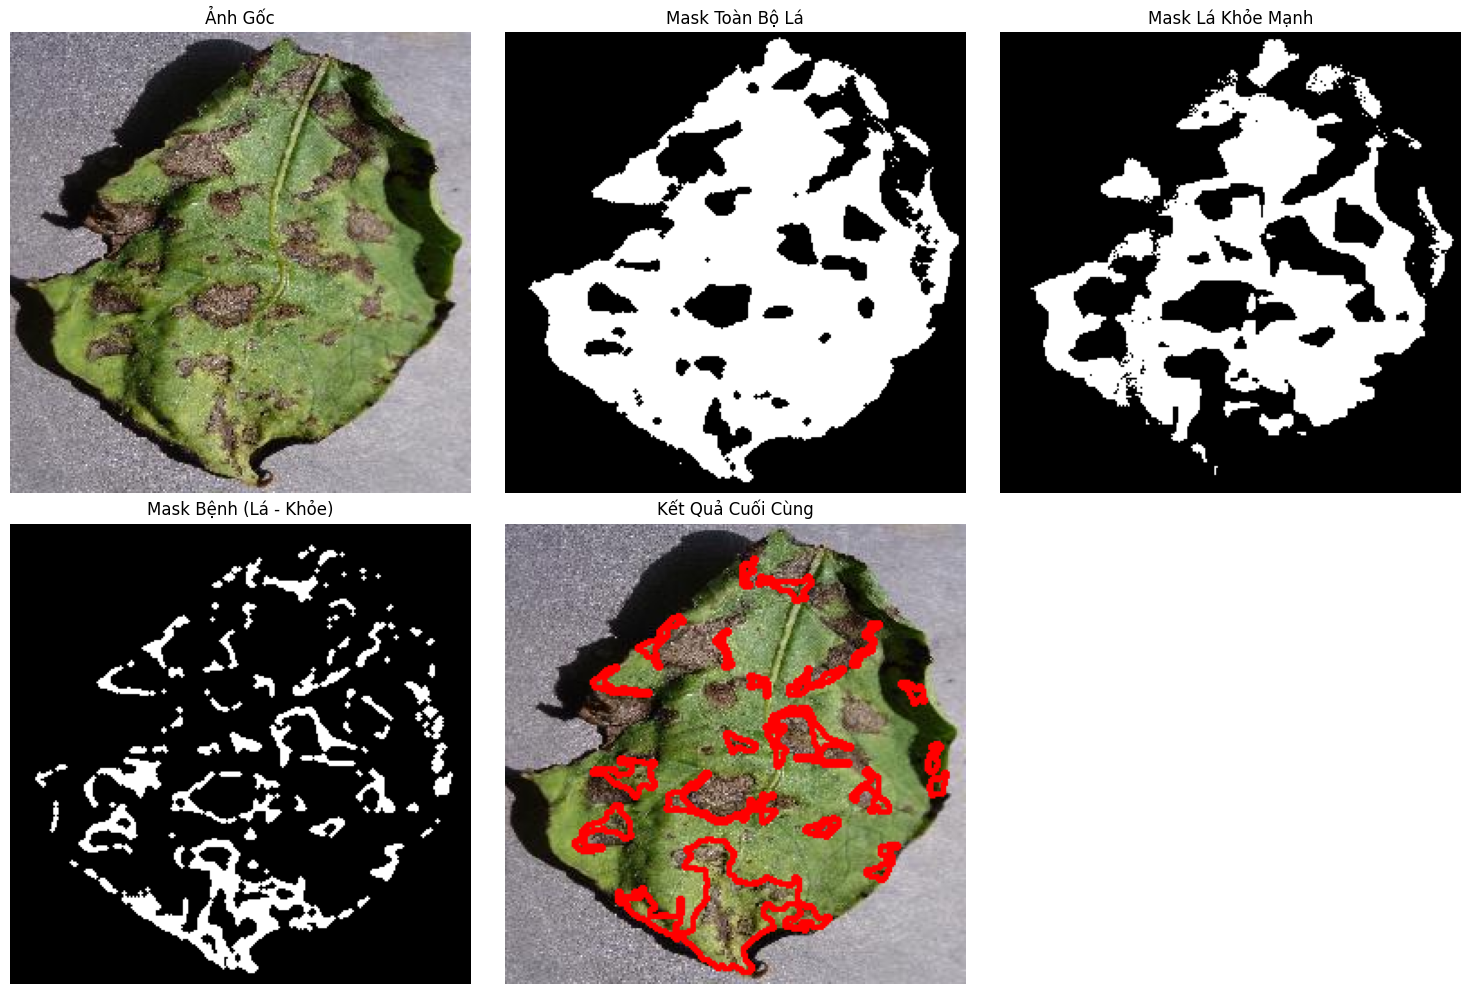

In [89]:
la_benh = cv.imread('img/la_benh4.jpg')
segment_by_excluding_green(la_benh)

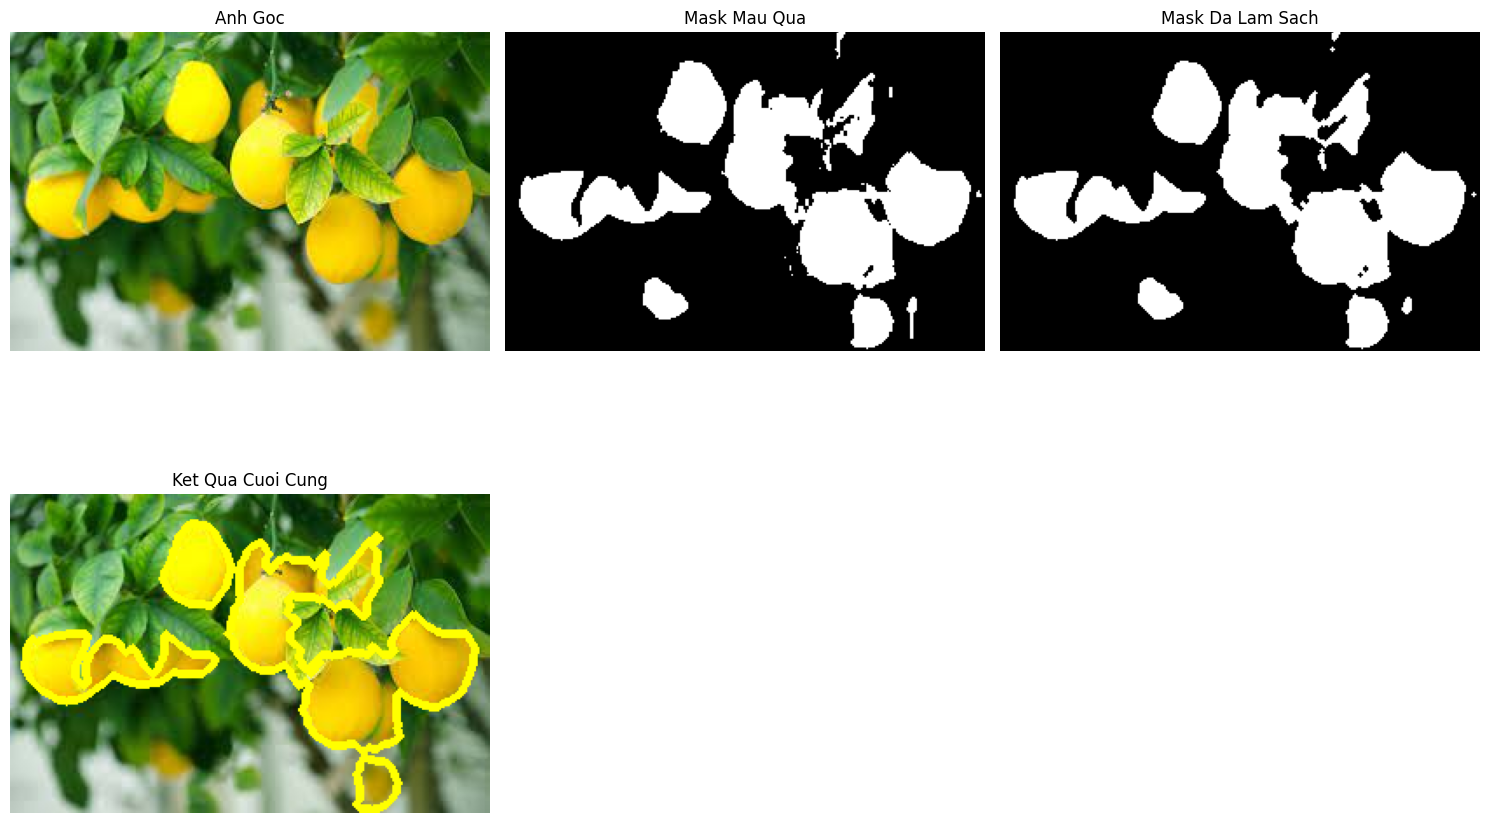

In [91]:
trai_chanh = cv.imread('img/lemon2.jpg')
count_fruits(trai_chanh, 'yellow')

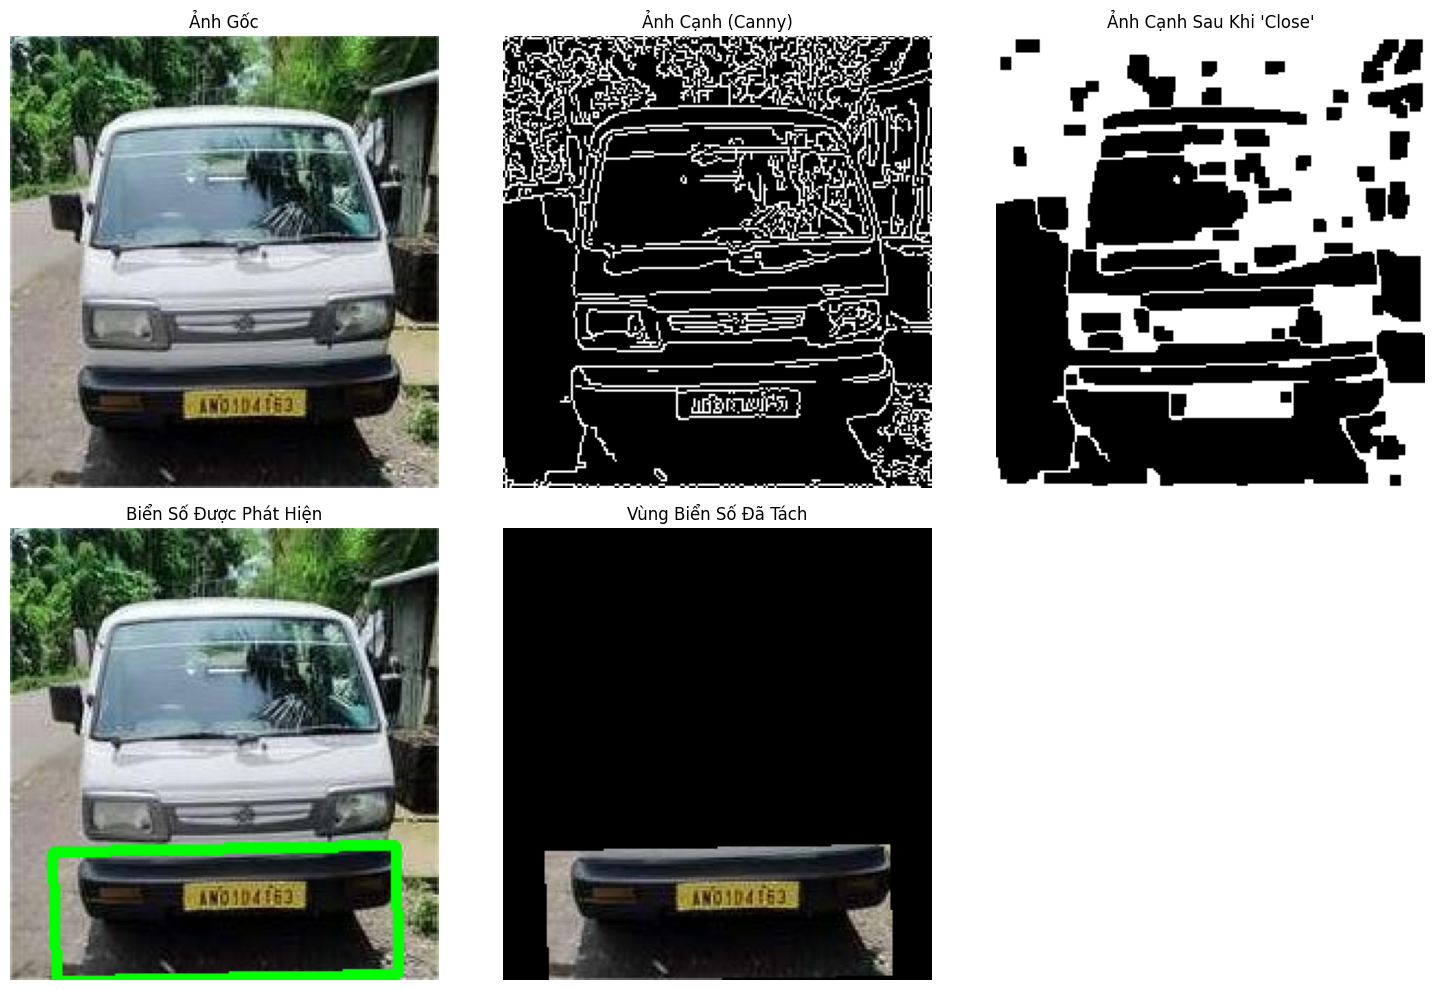

In [92]:
bien_so = cv.imread('img/bien_so2.jpg')
detect_license_plate(bien_so)

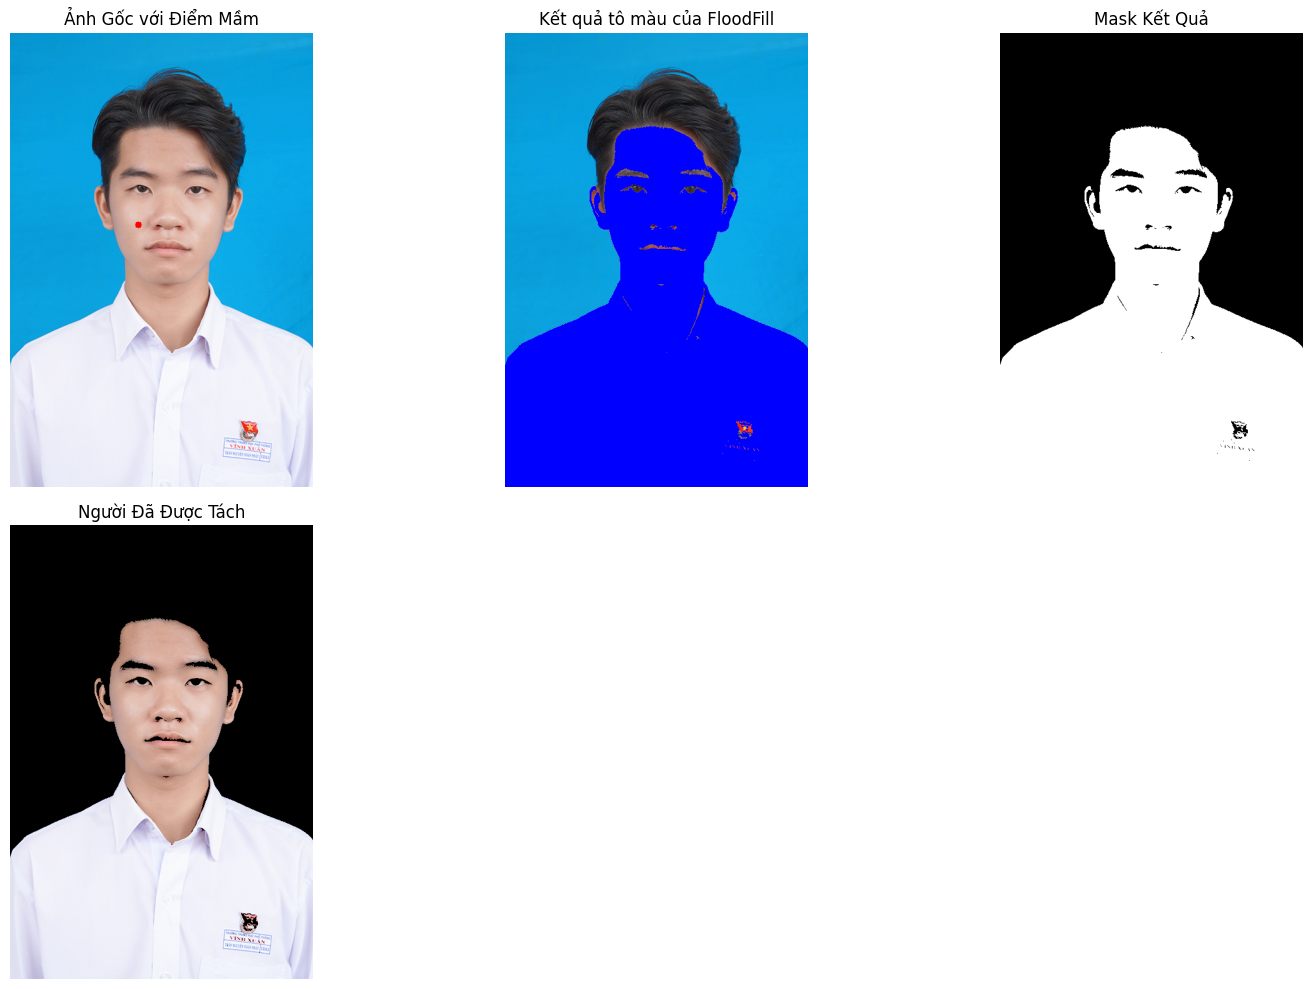

In [94]:
chan_dung = cv.imread('img/chan_dung.jpg')
segment_person(chan_dung, (200, 300), 90)